# **pandas操作及应用展示** 

In [119]:
# pip install --upgrade pyarrow
import pandas as pd
import numpy as np

## **1 part I 函数介绍**

### **1.1 分组，聚合 groupby,agg,apply**

分组核心：

1.不论分组键是数组、列表、字典、Series、函数，只要其与待分组变量的轴长度一致都可以传入groupby进行分组。

2.默认axis=0按行分组，可指定axis=1对列分组。

对数据进行分组操作的过程可以概括为：split-apply-combine三步：

1.按照键值（key）或者分组变量将数据分组。

2.对于每组应用我们的函数，这一步非常灵活，可以是python自带函数，可以是我们自己编写的函数。

3.将函数计算后的结果聚合。

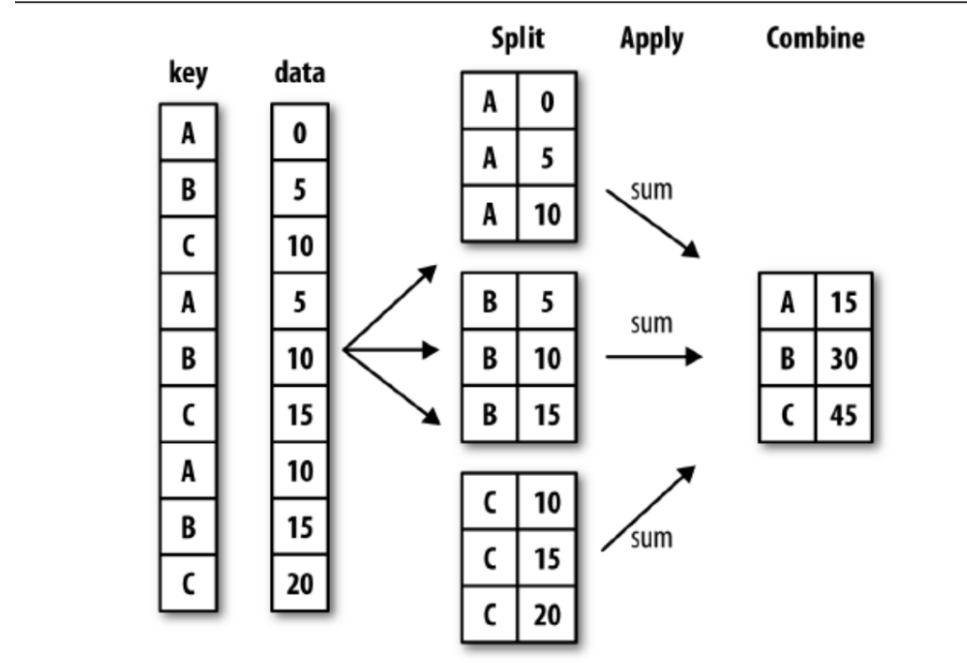

In [120]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
    'key2' : ['one', 'two', 'one', 'two', 'one'],
    'data1' : np.random.randn(5),
    'data2' : np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,1.218114,1.146477
1,a,two,-2.724108,0.632284
2,b,one,0.294228,-1.261671
3,b,two,-0.392884,0.677562
4,a,one,0.760890,-0.707482


In [121]:
df.sum()

key1               aabba
key2     onetwoonetwoone
data1          -0.843761
data2            0.48717
dtype: object

In [122]:
df.groupby(['key1'])#这里只是将DataFrame的'key1'列进行了一个分组，没有进行运算

In [123]:
df.groupby(['key1','key2'])#也可以按'key1'，'key2'同时进行分组

In [124]:
#对分组进行遍历
for k,v in df.groupby(['key1']):
    print('group key is:',k)
    print(v)

group key is: a
  key1 key2     data1     data2
0    a  one  1.218114  1.146477
1    a  two -2.724108  0.632284
4    a  one  0.760890 -0.707482
group key is: b
  key1 key2     data1     data2
2    b  one  0.294228 -1.261671
3    b  two -0.392884  0.677562


In [125]:
grouped = df['data1'].groupby(df['key1'])
#语法很简单，但是这里需要注意grouped的数据类型，它不再是一个数据框，而是一个GroupBy对象。
grouped

实际上，在这一步，我们并没有进行任何计算仅仅是创建用key1分组后创建了一个GroupBy对象，我们后面函数的任何操作都是基于这个对象的。对其求均值：

In [126]:
grouped.mean()

key1
a   -0.248368
b   -0.049328
Name: data1, dtype: float64

In [127]:
#对"key1","key2"一起分组，并对组内的"data1"求均值
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
#其实就是grouped.agg('mean')的简写。
means

key1  key2
a     one     0.989502
      two    -2.724108
b     one     0.294228
      two    -0.392884
Name: data1, dtype: float64

In [129]:
means = df['data1'].groupby([df['key1'], df['key2']]).agg('mean')

In [130]:
#以上我们的分组变量都是df内部的Series，实际上只要是和key1等长的数组也可以：
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

California  2005   -2.724108
            2006    0.294228
Ohio        2005    0.412615
            2006    0.760890
Name: data1, dtype: float64

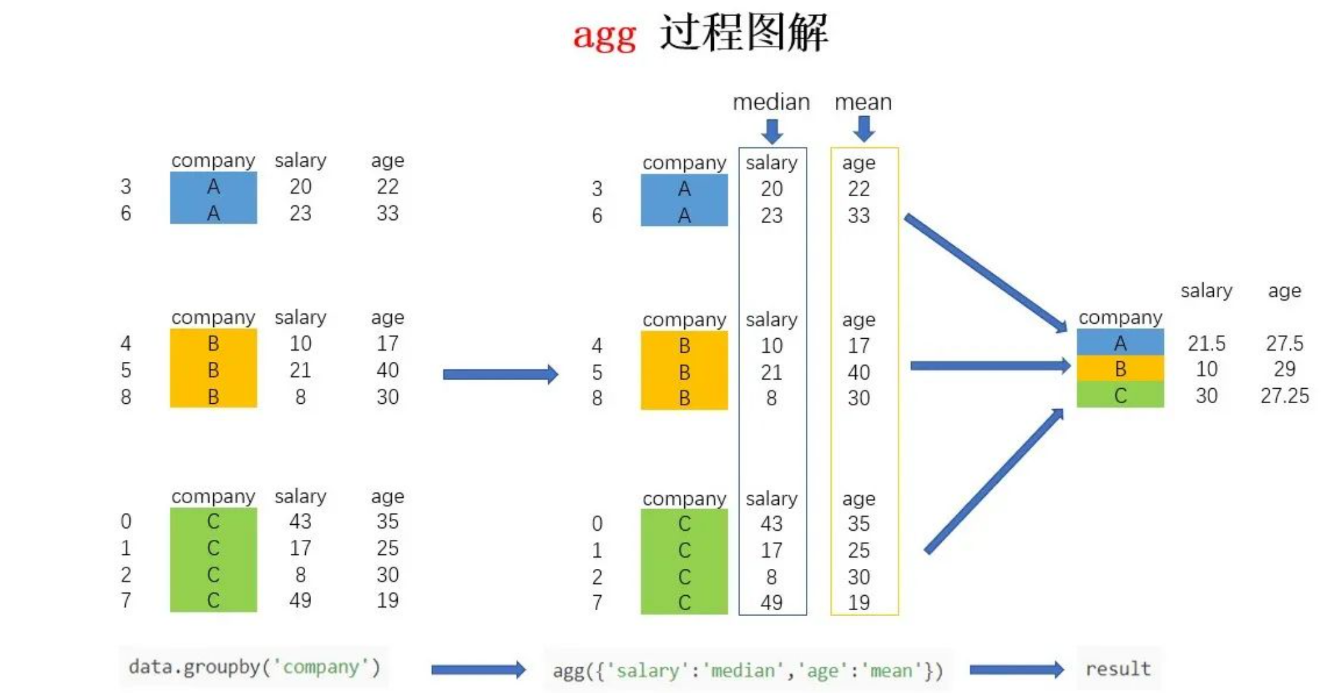

In [133]:
df = pd.DataFrame({'Country':['China','China', 'India', 'India', 'America', 'Japan', 'China', 'India'], 
 
                   'Income':[10000, 10000, 5000, 5002, 40000, 50000, 8000, 5000],
 
                    'Age':[5000, 4321, 1234, 4010, 250, 250, 4500, 4321]})
df

,Country,Income,Age
0,China,10000,5000
1,China,10000,4321
2,India,5000,1234
3,India,5002,4010
4,America,40000,250
5,Japan,50000,250
6,China,8000,4500
7,India,5000,4321


In [134]:
df_agg = df.groupby('Country').agg(['min', 'mean', 'max'])
print(df_agg)

        Income                        Age                   
           min          mean    max   min         mean   max
Country                                                     
America  40000  40000.000000  40000   250   250.000000   250
China     8000   9333.333333  10000  4321  4607.000000  5000
India     5000   5000.666667   5002  1234  3188.333333  4321
Japan    50000  50000.000000  50000   250   250.000000   250


对分组后的部分列进行聚合，某些情况下，只需要对部分数据进行不同的聚合操作，可以通过字典来构建

In [135]:
num_agg={'Age':['min','mean','max'],'Income':['min','mean','max']}
print(df.groupby('Country').agg(num_agg))

          Age                    Income                     
          min         mean   max    min          mean    max
Country                                                     
America   250   250.000000   250  40000  40000.000000  40000
China    4321  4607.000000  5000   8000   9333.333333  10000
India    1234  3188.333333  4321   5000   5000.666667   5002
Japan     250   250.000000   250  50000  50000.000000  50000


 正如之前所说，apply函数也通常可以与groupby函数一起使用。

###### DataFrame.apply(func, axis=0, broadcast=False, raw=False, reduce=None, args=(), **kwds)

函数定义:
 df.apply(func, axis=0, broadcast=False, raw=False,     reduce=None, args=(), **kwds)

函数的理解：
apply函数中可以来使用自定义的函数(func)；对于func中传递的参数，如果axis =0 应用于每一列上，如果axis=1应用于每一行上参数：

func : 自定义的函数
    函数应用在每一列或是每一行上
axis : {0 or 'index', 1 or 'columns'}, default 0
    * 0 or 'index': 应用函数在每一列上
    * 1 or 'columns': 应用函数在每一行上
args : 元组
    额外的给自定义函数传递一个元组参数
    array/series
 其中还是可以给自定义参数传递一个字典参数    
Returns
applied : Series or DataFrame

总的来说，apply函数比agg函数用法更灵活。

In [159]:
#分组应用
#求出不同性别中分数排名前三的成绩
gender=['男','女']
df=pd.DataFrame({
    'height':np.random.randint(150,190,100),
    'weight':np.random.randint(40,90,100),
    'gender':[gender[x] for x in np.random.randint(0,2,100)],
    'age':np.random.randint(15,90,100),
    'grade':np.random.randint(50,100,100)
}
)

In [160]:
df

,height,weight,gender,age,grade
0,173,65,男,65,56
1,186,59,男,65,84
2,164,85,女,80,87
3,176,56,男,64,52
4,155,65,女,33,53
...,...,...,...,...,...
95,175,56,女,83,75
96,152,57,男,54,87
97,179,61,女,15,65
98,180,54,男,85,56


In [139]:
#定义求top_n的函数

def get_topn(x,n):#x是series或者是DataFrame
    y=x.sort_values(by='grade',ascending=False)
    return y[:n]

In [161]:
df.groupby('gender').apply(get_topn,3)

height  weight gender  age  grade
gender                                      
女      65     158      75      女   72     98
       72     186      50      女   26     95
       64     159      44      女   27     95
男      9      171      54      男   52     98
       18     168      76      男   23     94
       7      181      87      男   79     94

In [142]:
#分组归一化
def normalize(x):
    return x-x.min()/(x.max()-x.min())

In [143]:
df.groupby('gender').apply(normalize)

,height,weight,age,grade
0,159.153846,85.166667,25.782609,91.913043
1,167.026316,50.145833,35.794521,67.979592
2,156.026316,42.145833,75.794521,59.979592
3,152.153846,49.166667,52.782609,75.913043
4,178.026316,86.145833,21.794521,52.979592
...,...,...,...,...
95,164.153846,87.166667,19.782609,48.913043
96,173.026316,86.145833,39.794521,69.979592
97,158.153846,47.166667,49.782609,88.913043
98,163.026316,52.145833,54.794521,90.979592


### **1.2 lambda函数 、map、applymap、apply**

在Python中，不通过def来声明函数名字，而是通过lambda关键字来定义的函数称为匿名函数。

lambda函数能接收任何数量(可以是0个)的参数，但只能返回一个表达式的值，lambda函数是一个函数对象，直接赋值给一个变量，这个变量就成了一个函数对象。

语法：lambda 参数：表达式

1.需要将一个函数对象作为参数来传递时，可以直接定义一个lambda函数（作为函数的参数或返回值）

2.要处理的业务符合lambda函数的情况（任意多个参数和一个返回值），并且只有一个地方会使用这个函数，不会在其他地方重用，可以使用lambda函数

3.与一些Python的内置函数配合使用，提高代码的可读性

In [144]:
# 无参数
lambda_a = lambda: 100
print(lambda_a())
 
# 一个参数
lambda_b = lambda num: num * 10
print(lambda_b(5))
 
# 多个参数
lambda_c = lambda a, b, c, d: a + b + c + d
print(lambda_c(1, 2, 3, 4))
 
# 表达式分支
lambda_d = lambda x: x if x % 2 == 0 else x + 1
print(lambda_d(6))
print(lambda_d(7))

100
50
10
6
8


In [145]:
frame=pd.DataFrame(np.arange(12.).reshape((4,3)),columns=list('bde'),index=['Utah','Ohio','Texas','Oregon'])
series=frame.iloc[0]
frame

,b,d,e
Utah,0.0,1.0,2.0
Ohio,3.0,4.0,5.0
Texas,6.0,7.0,8.0
Oregon,9.0,10.0,11.0


In [146]:
f=lambda x:x.max()-x.min()

In [147]:
frame.apply(f)

b    9.0
d    9.0
e    9.0
dtype: float64

In [148]:
ff=lambda x:2*x

In [149]:
frame['e'].map(ff)

Utah       4.0
Ohio      10.0
Texas     16.0
Oregon    22.0
Name: e, dtype: float64

In [150]:

df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
    'key2' : ['one', 'two', 'one', 'two', 'one'],
    'data1' : np.random.randn(5),
    'data2' : np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,0.240589,0.772819
1,a,two,0.322274,0.193537
2,b,one,-0.135327,-0.889405
3,b,two,1.349275,0.357723
4,a,one,0.333028,1.030633


In [151]:
f=lambda x:2*x
df['data1'].map(f)

0    0.481177
1    0.644549
2   -0.270654
3    2.698550
4    0.666056
Name: data1, dtype: float64

In [152]:
#applymap函数对Dataframe的每个元素进行操作
df1= pd.DataFrame({
                "sales1":[-1,2,3],
                "sales2":[3,-5,7],
               })
df1

,sales1,sales2
0,-1,3
1,2,-5
2,3,7


In [153]:
df1['sales1'].map(lambda x : 1 if x>0 else 0)
#df1.sales1就是一个Series

0    0
1    1
2    1
Name: sales1, dtype: int64

In [154]:
df1.applymap(lambda x:str(x)+'haha') #对每个元素进行相同的操作

,sales1,sales2
0,-1haha,3haha
1,2haha,-5haha
2,3haha,7haha


事实上，要对数据进行应用函数时，先看数据结构是DataFrame还是Series,Seriesj结构直接用map(),DataFrame结构的话如果根据对每行和每列应用的话，用apply，对每个元素进行相同的操作的话，直接applymap。

总结：

1.apply()是一种让函数作用于DataFrame中行或列的操作。

2.applymap()是一种让函数作用于DataFrame每一个元素的操作。

3.map()是一种让函数作用于Series每一个元素的操作。

### **1.3 重塑数据， melt,pivot_table,set_index,reset_index,swaplevel**

### melt函数：宽数据--->长数据

pandas.melt(frame, id_vars=None, value_vars=None, var_name=None, value_name=‘value’, col_level=None)

参数解释：

frame:要处理的数据集。

id_vars:不需要被转换的列名。

value_vars:需要转换的列名，如果剩下的列全部都要转换，就不用写了。

var_name（变量的名称）和value_name（值的名称）是自定义设置对应的列名。

col_level :如果列是MultiIndex，则使用此级别。

In [35]:
d = {'name': ['John','Bob','Shiela'], 'course': ['math','English','English'], 'age': ['21','22','23']}
df = pd.DataFrame(data = d)
df

,name,course,age
0,John,math,21
1,Bob,English,22
2,Shiela,English,23


设置 id_vars=['name']，则不需要转换的列是第三列 。所以age跟course合并成了一列。

In [36]:
pd.melt(df, id_vars = ['name'])

,name,variable,value
0,John,course,math
1,Bob,course,English
2,Shiela,course,English
3,John,age,21
4,Bob,age,22
5,Shiela,age,23


In [37]:
pd.melt(df, id_vars =['name'], value_vars =['course'])#设置 id_vars=['name'],value_vars=['course'] ， 则不需要转换的列是name 。需要转换的是 course列 ，那age就不受影响，就不会显示出来。

,name,variable,value
0,John,course,math
1,Bob,course,English
2,Shiela,course,English


对修改后的列设置新列名。

In [38]:
pd.melt(df, id_vars =['name'], value_vars =['course'], var_name ='ChangedVarname', value_name ='ChangedValname')

,name,ChangedVarname,ChangedValname
0,John,course,math
1,Bob,course,English
2,Shiela,course,English


### pivot_table：数据透视
pivot_table(data, values=None, index=None, columns=None,aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All')

pivot_table有四个最重要的参数：index、values、columns、aggfunc

每个pivot_table必须拥有一个index；

Values可以对需要的计算数据进行筛选；

aggfunc参数可以设置我们对数据聚合时进行的函数操作，默认是mean函数，即取均值；

Columns类似Index可以设置列层次字段，它不是一个必要参数，作为一种分割数据的可选方式（aggfunc也可以使用dict类型，如果dict中的内容与values不匹配时，以dict中为准）

#pivot_table就是转换各个维度去观察数据, aggfunc就是在数据转换过程中的过程函数

In [39]:
df = pd.DataFrame({'student': ['小红', '小红', '李华', '李华', '小天', '小天'],
                    'class': ['001','001','001','001','002','002'],
                   'subject': ['C', 'Java', 'Python', 'C', 'C', 'Python'],
                   'grades': [80,  90, 78, 90, 80, 78]})
df

,student,class,subject,grades
0,小红,001,C,80
1,小红,001,Java,90
2,李华,001,Python,78
3,李华,001,C,90
4,小天,002,C,80
5,小天,002,Python,78


index、columns参数必须传一个，否则会报错误：No group keys passed

In [40]:
df.pivot_table(index='subject')#只传index

,grades
subject,
C,83.333333
Java,90.000000
Python,78.000000


In [41]:
df.pivot_table(columns='subject')#只传column

subject,C,Java,Python
grades,83.333333,90.0,78.0


In [42]:
df.pivot_table(index='subject', aggfunc=lambda x: type(x))

,class,grades,student
subject,,,
C,<class 'pandas.core.frame.DataFrame'>,<class 'pandas.core.frame.DataFrame'>,<class 'pandas.core.frame.DataFrame'>
Java,<class 'pandas.core.frame.DataFrame'>,<class 'pandas.core.frame.DataFrame'>,<class 'pandas.core.frame.DataFrame'>
Python,<class 'pandas.core.frame.DataFrame'>,<class 'pandas.core.frame.DataFrame'>,<class 'pandas.core.frame.DataFrame'>


In [43]:
#可以看到其实aggfunc接受的参数是一个Pandas中的Series对象，那我们把Series转成列表看下里面是啥.
df.pivot_table(index='subject', aggfunc=lambda x: x.tolist()) #可以看到结果是通过指定维度后透视得到的值的列表

,class,grades,student
subject,,,
C,"[001, 001, 002]","[80, 90, 80]","[小红, 李华, 小天]"
Java,[001],[90],[小红]
Python,"[001, 002]","[78, 78]","[李华, 小天]"


In [44]:
#做些小练习来更深入理解pivot_table函数
df.pivot_table(index='class')#统计各个班的平均分

,grades
class,
001,84.5
002,79.0


In [45]:
df.pivot_table(index='class', aggfunc={'grades': np.mean, 'student': lambda x: len(x.unique())})#统计各个班级(class)的平均分以及班级学生人数。python中的unique() a = np.unique(A) 对于一维数组或者列表，
#unique函数去除其中重复的元素，并按元素由大到小返回一个新的无元素重复的元组或者列表  import numpy as np   A = [1, 2, 2, 5,3, 4, 3]   a =np.unique(A)  

,grades,student
class,,
001,84.5,2
002,79.0,1


In [46]:
#统计各个班级(class)的各个科目(subject)的平均分
df.pivot_table(index='class', columns='subject',  values=['grades')

subject,C,Java,Python
class,,,
001,85.0,90.0,78.0
002,80.0,NaN,78.0


In [47]:
#统计各个班级(class)的各个科目(subject)的最高分,平且将空值填充为0
df.pivot_table(index='class', columns='subject',  values='grades', aggfunc=max, fill_value=0)

subject,C,Java,Python
class,,,
001,90,90,78
002,80,0,78


In [48]:
#统计各个班级(class)的各个科目(subject)的人数
df.pivot_table(index='class', columns='subject', values='grades', aggfunc='count', fill_value=0)

subject,C,Java,Python
class,,,
001,2,1,1
002,1,0,1


In [49]:
#统计各个学生(student)的最高分,最低分,平均分
df.pivot_table(index='student', values='grades', aggfunc=[max, min, np.mean])

,max,min,mean
,grades,grades,grades
student,,,
小天,80,78,79
小红,90,80,85
李华,90,78,84


In [50]:
#上面是多级索引,可能你想去掉grades这一级, 可以参考下面方法
#stack()是行转列, 把grades从column变成了index, 再reset_index去掉grades
df.pivot_table(index='student', values='grades', aggfunc=[max, min, np.mean]).stack().reset_index(level=-1, drop=True) 

,max,min,mean
student,,,
小天,80,78,79
小红,90,80,85
李华,90,78,84


### set_index函数：将某一列或者某几列设置为index
keys : 要设置为索引的列名（如有多个应放在一个列表里）

drop : 将设置为索引的列删除，默认为True

append : 是否将新的索引追加到原索引后（即是否保留原索引），默认为False

inplace : 是否在原DataFrame上修改，默认为False,inplace=True 表示直接修改 df, 而不是返回新对象，和reset_index()用法一样

verify_integrity : 是否检查索引有无重复，默认为False,若设置为True会影响程序性能，慎用

In [51]:
df = pd.DataFrame({"month": [2, 6, 12, 10], "year": [2008, 2012, 2012, 2019], "day": [29, 30, 31, 31]})
df

,month,year,day
0,2,2008,29
1,6,2012,30
2,12,2012,31
3,10,2019,31


In [52]:
#可以使用已有的列替换默认的整数行索引
df.set_index("year")

,month,day
year,,
2008,2,29
2012,6,30
2012,12,31
2019,10,31


In [53]:
#我们看到替换行索引后该列默认被删除, 可以设置 drop=False 保留该列
df.set_index("year", drop=False)

,month,year,day
year,,,
2008,2,2008,29
2012,6,2012,30
2012,12,2012,31
2019,10,2019,31


In [54]:
#可以使用多个列去替换行索引, 这样将形成层级索引
df.set_index(["year", "month"])

day
year month     
2008 2       29
2012 6       30
     12      31
2019 10      31

In [55]:
#除了使用已有的列, 还可以使用自定义数据
df.set_index([pd.Index([3, 3, 9, 11], name="other"), "year"])

month  day
other year            
3     2008      2   29
      2012      6   30
9     2012     12   31
11    2019     10   31

In [56]:
#设置 append=True 可以将已有列附加到行索引, 这样就不是替换效果了
df.set_index("year", append=True) #对于 df 对象, 原有的索引是整数索引, 现在加入年份列, 变成层级索引, 第一层是整数索引, 第二层是年份

,,month,day
,year,,
0,2008,2,29
1,2012,6,30
2,2012,12,31
3,2019,10,31


### reset_index函数：将index重新变为列
是对set_index()的反向操作，让dataframe的index回归到原来的样子。默认的是将dataframe的index回设置为自然数。

可以将收集到的分组数据扁平化，把数据变成易于数据分析的格式。

drop: 重新设置索引后是否将原索引作为新的一列并入DataFrame，默认为False

inplace: 是否在原DataFrame上改动，默认为False

level: 如果索引(index)有多个列，仅从索引中删除level指定的列，默认删除所有列

col_level: 如果列名(columns)有多个级别，决定被删除的索引将插入哪个级别，默认插入第一级

col_fill: 如果列名(columns)有多个级别，决定其他级别如何命名

In [57]:
df = pd.DataFrame([('bird', 389.0), ('bird', 24.0), ('mammal', 80.5), ('mammal', np.nan)],
                  index=['falcon', 'parrot', 'lion', 'monkey'], columns=('class', 'max_speed'))
df

,class,max_speed
falcon,bird,389.0
parrot,bird,24.0
lion,mammal,80.5
monkey,mammal,NaN


In [58]:
#参数drop  False表示重新设置索引后将原索引作为新的一列并入DataFrame，True表示删除原索引
df1 = df.reset_index()
#df1 = df.reset_index(drop=True)
df1

,index,class,max_speed
0,falcon,bird,389.0
1,parrot,bird,24.0
2,lion,mammal,80.5
3,monkey,mammal,NaN


In [59]:
df #可以看到在默认的情况下原来的DataFrame是没有变的

,class,max_speed
falcon,bird,389.0
parrot,bird,24.0
lion,mammal,80.5
monkey,mammal,NaN


In [60]:
#参数inplace，默认为False， True表示在原DataFrame上修改，False将修改后的DataFrame作为新的对象返回
df2 = df.reset_index(inplace=True)
df2

In [61]:
df #可以看到在True的情况下原来的DataFrame被改变的，而没有返回新对象

,index,class,max_speed
0,falcon,bird,389.0
1,parrot,bird,24.0
2,lion,mammal,80.5
3,monkey,mammal,NaN


In [62]:
#参数level 如果索引有多个列，仅从索引中删除由level指定的列，默认删除所有列。
#输入整数时表示将index的names中下标为level的索引删除；输入为字符串时表示将名字为level的索引删除
index = pd.MultiIndex.from_tuples([('bird', 'falcon'), ('bird', 'parrot'), ('mammal', 'lion'), ('mammal', 'monkey')], names=['class', 'name'])
columns = pd.MultiIndex.from_tuples([('speed', 'max'), ('species', 'type')]) #pd.MultiIndex.from_tuples()是指从元组创建分层索引
df = pd.DataFrame([(389.0, 'fly'), ( 24.0, 'fly'), ( 80.5, 'run'), (np.nan, 'jump')], index=index, columns=columns)
df

speed species
                 max    type
class  name                 
bird   falcon  389.0     fly
       parrot   24.0     fly
mammal lion     80.5     run
       monkey    NaN    jump

In [63]:
df0 = df.reset_index()
df0

,class,name,speed,species
,,,max,type
0,bird,falcon,389.0,fly
1,bird,parrot,24.0,fly
2,mammal,lion,80.5,run
3,mammal,monkey,NaN,jump


In [64]:
df1 = df.reset_index(level=0)#level=0 删除了第一列
#df1 = df.reset_index(level=1) #level=1 删除了第二列
df1

,class,speed,species
,,max,type
name,,,
falcon,bird,389.0,fly
parrot,bird,24.0,fly
lion,mammal,80.5,run
monkey,mammal,NaN,jump


In [65]:
df2 = df.reset_index(level='name')
df2

,name,speed,species
,,max,type
class,,,
bird,falcon,389.0,fly
bird,parrot,24.0,fly
mammal,lion,80.5,run
mammal,monkey,NaN,jump


In [66]:
df

speed species
                 max    type
class  name                 
bird   falcon  389.0     fly
       parrot   24.0     fly
mammal lion     80.5     run
       monkey    NaN    jump

In [67]:
#参数col_level  如果列名(columns)有多个级别，决定被删除的索引将插入哪个级别，默认插入第一级(col_level=0)
df1 = df.reset_index(level=0, col_level=0)
df1

,class,speed,species
,,max,type
name,,,
falcon,bird,389.0,fly
parrot,bird,24.0,fly
lion,mammal,80.5,run
monkey,mammal,NaN,jump


In [68]:
df2 = df.reset_index(level=0, col_level=1)
df2

,,speed,species
,class,max,type
name,,,
falcon,bird,389.0,fly
parrot,bird,24.0,fly
lion,mammal,80.5,run
monkey,mammal,NaN,jump


In [69]:
#参数col_fill 列名填充. 重置索引时被删除的索引只能插入一个级别，如果列名(columns)有多个级别，
#那么这个列的列名的其他级别如何命名就由col_fill决定，默认不做填充，
#如果传入None则用被删除的索引的名字填充

df1 = df.reset_index(level=0, col_level=0, col_fill=None)
df1

,class,speed,species
,class,max,type
name,,,
falcon,bird,389.0,fly
parrot,bird,24.0,fly
lion,mammal,80.5,run
monkey,mammal,NaN,jump


In [70]:
df2 = df.reset_index(level=0, col_level=1, col_fill='species')
df2

,species,speed,species
,class,max,type
name,,,
falcon,bird,389.0,fly
parrot,bird,24.0,fly
lion,mammal,80.5,run
monkey,mammal,NaN,jump


In [71]:
df3 = df.reset_index(level=0, col_level=0, col_fill='genus')
df3

,class,speed,species
,genus,max,type
name,,,
falcon,bird,389.0,fly
parrot,bird,24.0,fly
lion,mammal,80.5,run
monkey,mammal,NaN,jump


### swaplevel函数：用于交换MultiIndex的级别。
它将级别i与级别j交换。调用此方法不会更改值的顺序。

i:要交换的第一级索引。可以将级别名称作为字符串传递。

j:要交换的二级索引。可以将级别名称作为字符串传递。参数类型可以混合。

In [72]:
frame = pd.DataFrame(np.arange(12).reshape((4, 3)),
                  index=[['a', 'a', 'b', 'b'], [1, 2, 1, 2]],
                  columns=[['Ohio', 'Ohio', 'Colorado'],
                           ['Green', 'Red', 'Green']])
frame.index.names = ['key1', 'key2']
frame.columns.names = ['state', 'color']
frame

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

In [73]:
frame.swaplevel('key1', 'key2')#可以看到返回互换了级别i和j的新对象，不改变原数据

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
2    a        3   4        5
1    b        6   7        8
2    b        9  10       11

### strftime函数：将格式代码作为输入，并返回特定格式的字符串。使用%Y 和%m 作为格式提取年份和月份。

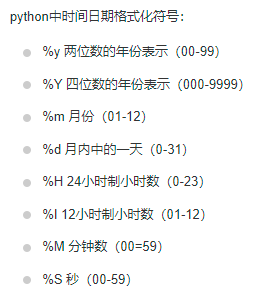

In [74]:
list_of_dates = ['2019-11-20', '2020-01-02', '2020-02-05','2020-03-10','2020-04-16']
employees=['Hisila', 'Shristi','Zeppy','Alina','Jerry']
df = pd.DataFrame({'Joined date': pd.to_datetime(list_of_dates)},index=employees)#to_datetime()将数据转换为时间类型数据
df['year'] = df['Joined date'].dt.strftime('%Y')
df['month'] = df['Joined date'].dt.strftime('%m')
df

,Joined date,year,month
Hisila,2019-11-20,2019,11
Shristi,2020-01-02,2020,01
Zeppy,2020-02-05,2020,02
Alina,2020-03-10,2020,03
Jerry,2020-04-16,2020,04


### **1.4 拼接数据型，concat，merge**


### concat函数：用来连接DataFrame对象
默认情况下是对两个DataFrame对象进行纵向连接；通过设置参数，也可以通过它实现DataFrame对象的横向连接。

### 纵向连接

#### （1）两个DataFrame对象的列完全相同

In [75]:
df1 = pd.DataFrame([['a', 1], ['b', 2]],
                columns=['letter', 'number'])
df1

,letter,number
0,a,1
1,b,2


In [76]:
df2 = pd.DataFrame([['c', 3], ['d', 4]],
                  columns=['letter', 'number'])
df2

,letter,number
0,c,3
1,d,4


In [77]:
#合并对象
pd.concat([df1, df2]) 

,letter,number
0,a,1
1,b,2
0,c,3
1,d,4


从上面的结果可以看出， concat默认纵向连接DataFrame对象， 并且合并之后不改变每个DataFrame子对象的index值， 因此我们可以在合并之后的DataFrame中看到index的值0和1重复了两次。
如果希望重新设置合并之后的DataFrame对象的index值， 可以添加ignore_index=True参数：

In [78]:
pd.concat([df1, df2], ignore_index=True)

,letter,number
0,a,1
1,b,2
2,c,3
3,d,4


#### （2）两个DataFrame对象的列不完全相同

In [79]:
df3 = pd.DataFrame([['c', 3, 'cat'], ['d', 4, 'dog']],
                  columns=['letter', 'number', 'animal'])
df3

,letter,number,animal
0,c,3,cat
1,d,4,dog


In [80]:
# 合并对象
pd.concat([df1, df3])  # sort=False : 列的顺序维持原样， 不进行重新排序。
#从结果可以看到， 因为df1中没有animal列， 所以在合并之后的DataFrame对象里， 所对应的元素都被设置成了NaN

,letter,number,animal
0,a,1,NaN
1,b,2,NaN
0,c,3,cat
1,d,4,dog


In [81]:
#如果只想合并相同的列， 我们可以添加上join='inner'参数：
pd.concat([df1, df3], join='inner')

,letter,number
0,a,1
1,b,2
0,c,3
1,d,4


### 横向合并：通过设置axis=1, 可以横向合并两个DataFrame对象

In [84]:
df4 = pd.DataFrame([['bird', 'polly'], ['monkey', 'george']],columns=['animal', 'name'])
df4

,animal,name
0,bird,polly
1,monkey,george


In [ ]:
df1

In [85]:
# 合并对象
pd.concat([df1, df4], axis=1)

,letter,number,animal,name
0,a,1,bird,polly
1,b,2,monkey,george


### merge函数：
基本的结构为：pd.merge(left, right, how='inner', on=None, left_on=None, right_on=None,left_index=False, right_index=False, sort=True，suffixes=('_x','_y'),copy=True)

left/right，两个不同的 DataFrame 对象。

on，指定用于连接的键（即列标签的名字），该键必须同时存在于左右两个 DataFrame 中，如果没有指定，并且其他参数也未指定， 那么将会以两个 DataFrame 的列名交集做为连接键。

left_on，指定左侧 DataFrame 中作连接键的列名。该参数在左、右列标签名不相同，但表达的含义相同时非常有用。

right_on，指定左侧 DataFrame 中作连接键的列名。

left_index，布尔参数，默认为 False。如果为 True 则使用左侧 DataFrame 的行索引作为连接键，若 DataFrame 具有多层
索引(MultiIndex)，则层的数量必须与连接键的数量相等。

right_index，布尔参数，默认为 False。如果为 True 则使用左侧 DataFrame 的行索引作为连接键。

how，要执行的合并类型，从 {'left', 'right', 'outer', 'inner'} 中取值，默认为“inner”内连接。

sort，布尔值参数，默认为True，它会将合并后的数据进行排序；若设置为 False，则按照 how 给定的参数值进行排序。

suffixes，字符串组成的元组。当左右 DataFrame 存在相同列名时，通过该参数可以在相同的列名后附加后缀名，默认为('_x','_y')。

copy，默认为 True，表示对数据进行复制

In [86]:
left = pd.DataFrame({ 
   'id':[1,2,3,4], 
   'Name': ['Smith', 'Maiki', 'Hunter', 'Hilen'], 
   'subject_id':['sub1','sub2','sub4','sub6']}) 
left

,id,Name,subject_id
0,1,Smith,sub1
1,2,Maiki,sub2
2,3,Hunter,sub4
3,4,Hilen,sub6


In [87]:
right = pd.DataFrame({ 
    'id':[1,2,3,4], 
   'Name': ['William', 'Albert', 'Tony', 'Allen'], 
   'subject_id':['sub2','sub4','sub3','sub6']}) 
right

,id,Name,subject_id
0,1,William,sub2
1,2,Albert,sub4
2,3,Tony,sub3
3,4,Allen,sub6


In [88]:
#在单个键上进行合并操作
pd.merge(left,right,on='id') #通过 on 参数指定一个连接键，然后对上述 DataFrame 进行合并操作

,id,Name_x,subject_id_x,Name_y,subject_id_y
0,1,Smith,sub1,William,sub2
1,2,Maiki,sub2,Albert,sub4
2,3,Hunter,sub4,Tony,sub3
3,4,Hilen,sub6,Allen,sub6


In [89]:
#在多个键上进行合并操作
pd.merge(left,right,on=['id','subject_id'])

,id,Name_x,subject_id,Name_y
0,4,Hilen,sub6,Allen


In [90]:
#使用how参数合并
#通过how参数可以确定 DataFrame 中要包含哪些键，如果在左表、右表都不存的键，那么合并后该键对应的值为 NaN
pd.merge(left,right,on='subject_id',how="left") #left join 左连接是左侧DataFrame取全部数据，右侧DataFrame匹配左侧DataFrame

,id_x,Name_x,subject_id,id_y,Name_y
0,1,Smith,sub1,NaN,NaN
1,2,Maiki,sub2,1.0,William
2,3,Hunter,sub4,2.0,Albert
3,4,Hilen,sub6,4.0,Allen


In [91]:
pd.merge(left,right,on='subject_id',how="right") #right join 右连接与左连接类似

,id_x,Name_x,subject_id,id_y,Name_y
0,2.0,Maiki,sub2,1,William
1,3.0,Hunter,sub4,2,Albert
2,NaN,NaN,sub3,3,Tony
3,4.0,Hilen,sub6,4,Allen


In [92]:
pd.merge(left,right,on='subject_id',how="outer") #outer join(并集) 全连接

,id_x,Name_x,subject_id,id_y,Name_y
0,1.0,Smith,sub1,NaN,NaN
1,2.0,Maiki,sub2,1.0,William
2,3.0,Hunter,sub4,2.0,Albert
3,4.0,Hilen,sub6,4.0,Allen
4,NaN,NaN,sub3,3.0,Tony


In [93]:
pd.merge(left,right,on='subject_id',how="inner") #inner join(交集) 内连接

,id_x,Name_x,subject_id,id_y,Name_y
0,2,Maiki,sub2,1,William
1,3,Hunter,sub4,2,Albert
2,4,Hilen,sub6,4,Allen


## **part II 问题分析**

### **2.1 数据以及最终目的。**

In [155]:
#导入库和相关数据
import pandas as pd
import numpy as np
from datetime import datetime
orders = pd.read_parquet("shopify_orders.parquet")

In [158]:
#原始数据
orders.head()
orders['Day'].min()

'2014-01-01'

#### 数据：每一行是一次下单，每次下单会有顾客id，以及这个订单是不是这个顾客的第一次 以及订单量和销售额等数据*

### **最终结果**
#### cohort是每个顾客第一次下单的时间，Day是每笔订单的购买时间
#### 以total_sales为例，16年7月，第一次购买的顾客的销售额，也就是新增购买的销售额是48792.62。returning表示16年7月第一次购买以后，这些顾客后面的复购情况，在同月复购的销售额是127003.27，在下个月的复购情况就减少到了45.95。

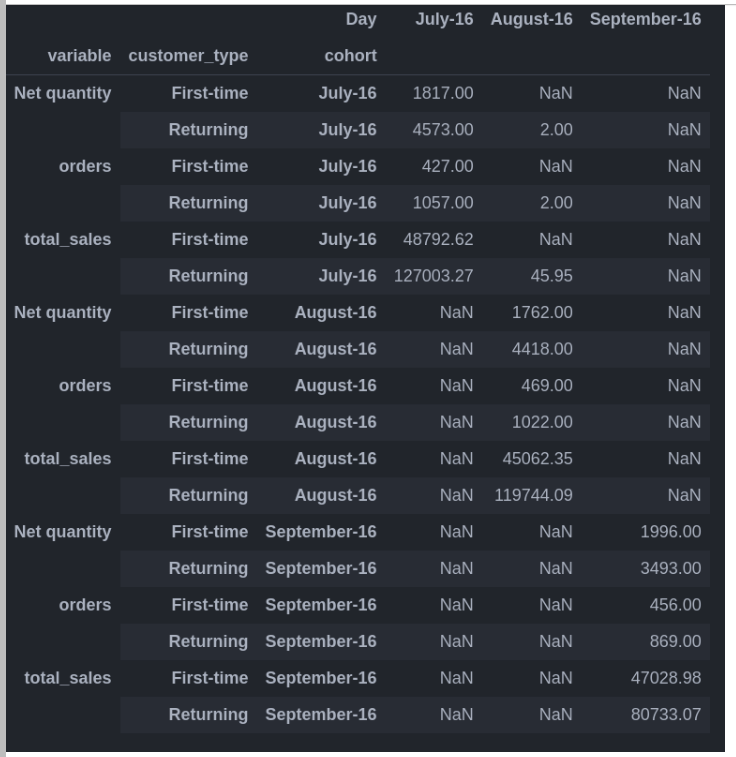

**实现思路** 找到每个订单对应顾客的cohort，按照cohort,customer_type,以及Day对订单分组。然后计算销量的和即可。

### **2.2 生成cohort变量，两种思路。**

第一种，拿出first-time对应的day和顾客id,形成df，然后拼接。然后以id为主键，对原始的表进行拼接。左表是orders,右面的表是id+第一次购物时1间。如果为空，拼接方式选择how=left,然后如果有的id的first-time为空值，说明第一次购买在数据区间之前。随意给个日期即可。

第二种，groupby id,然后每个id的最早日期拿出来，即可。对于全是returning类型的顾客，随意设置一个日期即可。

### **2.3 分组聚合**

按照cohort，type，Day分组，对需要统计的指标求和即可
### **2.4 重塑结果**

分组聚合以后的数据，cohort,type,Day都是索引，变量是列名，

melt函数、pivot_table函数

## part III **代码实现**

### **3.1 生成cohort变量，merge版本**

**对消费者进行分类1：首先选取这段时间内first_time的消费者,记为orders_First**

In [96]:
#完整运行代码
#1.将日期从object转化为datetime格式
orders["Day"] = pd.to_datetime(orders["Day"])

#2.选取每个id对应的first-time，最终令其为cohort
#注意这里有个前提假设，即每个id只有一个first-time，即为其最早购买时间（实际数据并不是）

#2.1选取customer_type==Firts-time的行，'Day','Customer ID'两列，并将'Day'改名为'cohort'
index_First=orders['customer_type']=='First-time'
orders_First=orders.loc[index_First,['Day','Customer ID']]
orders_First.rename(columns={'Day':'cohort'},inplace=True)
orders_First

,cohort,Customer ID
8,2014-10-29,7355366
9,2015-05-28,4143828
12,2014-03-24,7964705
13,2017-08-22,4474953
18,2014-09-06,6291462
...,...,...
100421,2014-08-30,1036051
100423,2016-11-09,4876007
100425,2015-04-19,8178559
100428,2015-01-10,5870922


In [97]:
#去除重复first-time，以最先开始时间为准
orders_First=orders_First.sort_values(by=['Customer ID','cohort']).drop_duplicates(subset='Customer ID',keep='first')
orders_First

,cohort,Customer ID
51216,2014-07-08,1000037
53400,2015-02-18,1000184
421,2016-08-02,1000443
22334,2015-08-26,1000617
73603,2015-02-09,1000814
...,...,...
30629,2014-07-11,9998934
40371,2017-01-20,9999619
88436,2016-04-04,9999624
47203,2015-09-17,9999752


In [98]:
#2.2将orders_First与order合并，左连接，主键为Customer ID
orders_merge=pd.merge(orders,orders_First,on="Customer ID",how='left')
orders_merge.rename(columns={'Day_x':'Day','Day_y':'cohort'},inplace=True)
orders_merge

,Day,customer_type,Customer ID,orders,total_sales,Returns,Ordered quantity,Gross sales,Net sales,Shipping,Tax,Net quantity,Returned quantity,Discounts,cohort
0,2018-09-02,Returning,7609456,1,31.25,-0.0,7,27.21,27.21,4.04,0.00,7,0,-0.0,2018-09-02
1,2017-07-23,Returning,4782112,1,152.75,-0.0,2,134.77,134.77,0.00,17.98,2,0,-0.0,2017-07-23
2,2018-02-25,Returning,5245146,1,10.25,-0.0,2,10.25,10.25,0.00,0.00,2,0,-0.0,2018-02-25
3,2020-08-09,Returning,7033470,1,1149.84,-0.0,7,1014.65,1014.65,0.00,135.19,7,0,-0.0,2020-08-09
4,2020-06-16,Returning,7560082,1,0.00,-0.0,5,0.00,0.00,0.00,0.00,5,0,-0.0,2020-06-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100431,2020-04-18,Returning,3865681,1,289.90,-0.0,2,289.90,289.90,0.00,0.00,2,0,-0.0,2020-04-18
100432,2018-11-24,Returning,8628394,1,69.05,-0.0,2,54.30,54.30,14.75,0.00,2,0,-0.0,2018-11-24
100433,2020-05-19,Returning,8728921,1,43.35,-0.0,1,40.40,40.40,2.95,0.00,1,0,-0.0,2020-05-19
100434,2019-10-15,Returning,3139300,1,39.23,-0.0,1,39.23,39.23,0.00,0.00,1,0,-0.0,2019-10-15


**对消费者进行分类2：将只有return_time的消费者时间赋值一个之前的时间**

In [99]:
# 2.3将只有return的顾客cohort赋值为'2013-12-31'
return_customer=orders_merge['cohort'].isnull()
orders_merge.loc[return_customer,'cohort']='2013-12-31'
orders_merge['cohort']=pd.to_datetime(orders_merge['cohort'])
orders_merge['cohort']

0        2018-09-02
1        2017-07-23
2        2018-02-25
3        2020-08-09
4        2020-06-16
            ...    
100431   2020-04-18
100432   2018-11-24
100433   2020-05-19
100434   2019-10-15
100435   2019-11-24
Name: cohort, Length: 100436, dtype: datetime64[ns]

### **3.2分组聚合**

In [100]:
#以上完成了step1，即将每个顾客id对应的first-time作为一列加入orders
#3.按照题目要求进行分组
#3.1首先选取我们所需的列
orders_select=orders_merge[['Day','cohort','customer_type','Net quantity','orders','total_sales']]
orders_select

,Day,cohort,customer_type,Net quantity,orders,total_sales
0,2018-09-02,2018-09-02,Returning,7,1,31.25
1,2017-07-23,2017-07-23,Returning,2,1,152.75
2,2018-02-25,2018-02-25,Returning,2,1,10.25
3,2020-08-09,2020-08-09,Returning,7,1,1149.84
4,2020-06-16,2020-06-16,Returning,5,1,0.00
...,...,...,...,...,...,...
100431,2020-04-18,2020-04-18,Returning,2,1,289.90
100432,2018-11-24,2018-11-24,Returning,2,1,69.05
100433,2020-05-19,2020-05-19,Returning,1,1,43.35
100434,2019-10-15,2019-10-15,Returning,1,1,39.23


In [101]:
#3.2按照要求进行分组，并重置索引
orders_group=orders_select.groupby([pd.Grouper(key='Day',freq="M"),'customer_type',pd.Grouper(key='cohort',freq="M")]).sum()
orders_group.reset_index(['Day','customer_type','cohort'],inplace=True)
orders_group

,Day,customer_type,cohort,Net quantity,orders,total_sales
0,2014-01-31,First-time,2014-01-31,6476,1553,174082.81
1,2014-01-31,Returning,2013-12-31,6,4,242.08
2,2014-02-28,First-time,2014-02-28,7724,1476,164669.52
3,2014-02-28,Returning,2013-12-31,30,5,734.62
4,2014-03-31,First-time,2014-03-31,5941,1424,177423.96
...,...,...,...,...,...,...
415,2020-09-30,Returning,2020-08-31,64,8,1143.54
416,2020-09-30,Returning,2020-09-30,6976,1665,162071.92
417,2020-10-31,First-time,2020-10-31,57,11,1851.98
418,2020-10-31,Returning,2020-09-30,43,8,764.35


### **3.3 数据重塑** 

In [102]:
#3.3将Net quantity orders total_sales转化到列上，为pivot_table做准备
orders_group=orders_group.melt(id_vars=['Day','cohort','customer_type'])
orders_group

,Day,cohort,customer_type,variable,value
0,2014-01-31,2014-01-31,First-time,Net quantity,6476.00
1,2014-01-31,2013-12-31,Returning,Net quantity,6.00
2,2014-02-28,2014-02-28,First-time,Net quantity,7724.00
3,2014-02-28,2013-12-31,Returning,Net quantity,30.00
4,2014-03-31,2014-03-31,First-time,Net quantity,5941.00
...,...,...,...,...,...
1255,2020-09-30,2020-08-31,Returning,total_sales,1143.54
1256,2020-09-30,2020-09-30,Returning,total_sales,162071.92
1257,2020-10-31,2020-10-31,First-time,total_sales,1851.98
1258,2020-10-31,2020-09-30,Returning,total_sales,764.35


In [103]:
#构建透视表，以variable,customer_type,cohort为索引，Day为列
#4.呈现pivot_table
orders_pivot=orders_group.pivot_table(index=['cohort','variable','customer_type'],columns='Day',values='value')
orders_pivot

Day                                    2014-01-31  2014-02-28  2014-03-31  \
cohort     variable     customer_type                                       
2013-12-31 Net quantity Returning            6.00       30.00       20.00   
           orders       Returning            4.00        5.00        5.00   
           total_sales  Returning          242.08      734.62      737.26   
2014-01-31 Net quantity First-time        6476.00         NaN         NaN   
                        Returning             NaN         NaN         NaN   
...                                           ...         ...         ...   
2020-10-31 Net quantity Returning             NaN         NaN         NaN   
           orders       First-time            NaN         NaN         NaN   
                        Returning             NaN         NaN         NaN   
           total_sales  First-time            NaN         NaN         NaN   
                        Returning             NaN         NaN         NaN   

Day                                    2014-04-30  2014-05-31  2014-06-30  \
cohort     variable     customer_type                                       
2013-12-31 Net quantity Returning             NaN       19.00       25.00   
           orders       Returning             NaN        6.00        5.00   
           total_sales  Returning             NaN      391.38      413.23   
2014-01-31 Net quantity First-time            NaN         NaN         NaN   
                        Returning             NaN         NaN         NaN   
...                                           ...         ...         ...   
2020-10-31 Net quantity Returning             NaN         NaN         NaN   
           orders       First-time            NaN         NaN         NaN   
                        Returning             NaN         NaN         NaN   
           total_sales  First-time            NaN         NaN         NaN   
                        Returning             NaN         NaN         NaN   

Day                                    2014-07-31  2014-08-31  2014-09-30  \
cohort     variable     customer_type                                       
2013-12-31 Net quantity Returning            17.0       17.00       46.00   
           orders       Returning             7.0        4.00       11.00   
           total_sales  Returning           444.6      466.37     1914.28   
2014-01-31 Net quantity First-time            NaN        1.00         NaN   
                        Returning             NaN         NaN         NaN   
...                                           ...         ...         ...   
2020-10-31 Net quantity Returning             NaN         NaN         NaN   
           orders       First-time            NaN         NaN         NaN   
                        Returning             NaN         NaN         NaN   
           total_sales  First-time            NaN         NaN         NaN   
                        Returning             NaN         NaN         NaN   

Day                                    2014-10-31  ...  2020-01-31  \
cohort     variable     customer_type              ...               
2013-12-31 Net quantity Returning           23.00  ...       62.00   
           orders       Returning            6.00  ...       13.00   
           total_sales  Returning          573.27  ...     1266.11   
2014-01-31 Net quantity First-time            NaN  ...         NaN   
                        Returning             NaN  ...         NaN   
...                                           ...  ...         ...   
2020-10-31 Net quantity Returning             NaN  ...         NaN   
           orders       First-time            NaN  ...         NaN   
                        Returning             NaN  ...         NaN   
           total_sales  First-time            NaN  ...         NaN   
                        Returning             NaN  ...         NaN   

Day                                    2020-02-29  2020-03-31  2020-04-30  \
cohort

In [104]:
#更改列和索引的日期格式
orders_pivot.rename(columns=lambda x: x.strftime("%B-%y"),inplace=True)
orders_pivot.rename(index=lambda x: x.strftime("%B-%y"), level="cohort",inplace=True)

In [105]:
#切片索引
months = ["July-16", "August-16", "September-16"]
orders_months=orders_pivot.loc[pd.IndexSlice[months,:, :], months]
orders_months

Day                                        July-16  August-16  September-16
cohort       variable     customer_type                                    
July-16      Net quantity First-time       1815.00        NaN           NaN
                          Returning        4570.00       2.00           NaN
             orders       First-time        426.00        NaN           NaN
                          Returning        1055.00       2.00           NaN
             total_sales  First-time      48798.41        NaN           NaN
                          Returning      126915.20      45.95           NaN
August-16    Net quantity First-time           NaN    1742.00           NaN
                          Returning            NaN    4385.00           NaN
             orders       First-time           NaN     466.00           NaN
                          Returning            NaN    1016.00           NaN
             total_sales  First-time           NaN   44614.34           NaN
                          Returning            NaN  119003.16           NaN
September-16 Net quantity First-time           NaN        NaN       1992.00
                          Returning            NaN        NaN       3475.00
             orders       First-time           NaN        NaN        454.00
                          Returning            NaN        NaN        865.00
             total_sales  First-time           NaN        NaN      46959.38
                          Returning            NaN        NaN      80484.24

In [106]:
#交换索引cohort和customer_type
orders_months=orders_months.swaplevel('cohort','customer_type')

In [107]:
#交换索引variable和customer_type
orders_months.swaplevel('variable','customer_type')

Day                                        July-16  August-16  September-16
variable     customer_type cohort                                          
Net quantity First-time    July-16         1815.00        NaN           NaN
             Returning     July-16         4570.00       2.00           NaN
orders       First-time    July-16          426.00        NaN           NaN
             Returning     July-16         1055.00       2.00           NaN
total_sales  First-time    July-16        48798.41        NaN           NaN
             Returning     July-16       126915.20      45.95           NaN
Net quantity First-time    August-16           NaN    1742.00           NaN
             Returning     August-16           NaN    4385.00           NaN
orders       First-time    August-16           NaN     466.00           NaN
             Returning     August-16           NaN    1016.00           NaN
total_sales  First-time    August-16           NaN   44614.34           NaN
             Returning     August-16           NaN  119003.16           NaN
Net quantity First-time    September-16        NaN        NaN       1992.00
             Returning     September-16        NaN        NaN       3475.00
orders       First-time    September-16        NaN        NaN        454.00
             Returning     September-16        NaN        NaN        865.00
total_sales  First-time    September-16        NaN        NaN      46959.38
             Returning     September-16        NaN        NaN      80484.24

### **3.4 cohort生成方式2，以及截图结果如何得到**

In [162]:
orders['Day']=orders['Day'].map(lambda x:str(x)[:7]) #转化成月份 ,因为最后只要按照月份分组就可以了
grouped1=orders.groupby('Customer ID') #按照顾客id分组

In [109]:
def create_cohort(df):
    if (df['customer_type']=='Returning').all(): #第二类顾客，第一次购买不在数据区间内的顾客
        df['cohort']='2008-01' #随意指定一个之前的日期
    else:
        df['cohort']=df['Day'].min() #对于第一类顾客，最早的下单就是第一次购买时间
    return df

In [110]:
orders2=grouped1.apply(create_cohort) #自定义函数应用apply的一般会比较慢，因为相当于写循环对每个组进行操作，
orders2

,Day,customer_type,Customer ID,orders,total_sales,Returns,Ordered quantity,Gross sales,Net sales,Shipping,Tax,Net quantity,Returned quantity,Discounts,cohort
0,2018-09,Returning,7609456,1,31.25,-0.0,7,27.21,27.21,4.04,0.00,7,0,-0.0,2018-09
1,2017-07,Returning,4782112,1,152.75,-0.0,2,134.77,134.77,0.00,17.98,2,0,-0.0,2017-07
2,2018-02,Returning,5245146,1,10.25,-0.0,2,10.25,10.25,0.00,0.00,2,0,-0.0,2018-02
3,2020-08,Returning,7033470,1,1149.84,-0.0,7,1014.65,1014.65,0.00,135.19,7,0,-0.0,2020-08
4,2020-06,Returning,7560082,1,0.00,-0.0,5,0.00,0.00,0.00,0.00,5,0,-0.0,2020-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100431,2020-04,Returning,3865681,1,289.90,-0.0,2,289.90,289.90,0.00,0.00,2,0,-0.0,2020-04
100432,2018-11,Returning,8628394,1,69.05,-0.0,2,54.30,54.30,14.75,0.00,2,0,-0.0,2018-11
100433,2020-05,Returning,8728921,1,43.35,-0.0,1,40.40,40.40,2.95,0.00,1,0,-0.0,2020-05
100434,2019-10,Returning,3139300,1,39.23,-0.0,1,39.23,39.23,0.00,0.00,1,0,-0.0,2019-10


#### **截图结果**

In [111]:
#同一个顾客id有两次购买
test_df=orders[orders['Customer ID']==5985925] 
test_df

,Day,customer_type,Customer ID,orders,total_sales,Returns,Ordered quantity,Gross sales,Net sales,Shipping,Tax,Net quantity,Returned quantity,Discounts
2492,2018-04,Returning,5985925,1,126.84,-0.0,5,126.84,126.84,0.00,0.0,5,0,-0.00
39579,2016-07,Returning,5985925,1,24.94,-0.0,1,16.95,16.95,7.99,0.0,1,0,-0.00
45193,2016-07,First-time,5985925,1,946.45,-0.0,15,938.48,938.48,7.97,0.0,15,0,-0.00
49990,2018-04,First-time,5985925,1,219.56,-0.0,11,218.90,213.57,5.99,0.0,11,0,-5.33
54085,2018-04,Returning,5985925,1,33.30,-0.0,2,33.30,33.30,0.00,0.0,2,0,-0.00
58418,2016-07,Returning,5985925,1,35.57,-0.0,1,35.57,35.57,0.00,0.0,1,0,-0.00
73268,2018-04,Returning,5985925,1,27.25,-0.0,5,27.25,27.25,0.00,0.0,5,0,-0.00
92951,2018-04,Returning,5985925,1,68.30,-0.0,4,68.30,68.30,0.00,0.0,4,0,-0.00


In [112]:
#怎么把两个顾客区分开，根据购买日期，购买日期离那个first-time对应的date近，并且在first-time对应的date之后的订单定义为同一个顾客的订单
fr_date=test_df[test_df['customer_type']=='First-time']['Day'].values
fr_date.sort()
fr_date

array(['2016-07', '2018-04'], dtype=object)

In [113]:
#比较date在哪个区间，cohort赋给左区间断点
def func(date):
    try:
        index=list(date<fr_date).index(True)-1
    except:
        index=len(fr_date)-1
    cohort=fr_date[index]
    return cohort

In [114]:
test_df['cohort']=test_df['Day'].apply(func)
test_df[['Day','customer_type','cohort']]

<ipython-input-114-c0f24190a622>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cohort']=test_df['Day'].apply(func)


,Day,customer_type,cohort
2492,2018-04,Returning,2018-04
39579,2016-07,Returning,2016-07
45193,2016-07,First-time,2016-07
49990,2018-04,First-time,2018-04
54085,2018-04,Returning,2018-04
58418,2016-07,Returning,2016-07
73268,2018-04,Returning,2018-04
92951,2018-04,Returning,2018-04


In [115]:
#将上面的过程放到函数里
def new_cohort(df):
    if (df['customer_type']=='Returning').all(): #第二类顾客，第一次购买不在数据区间内的顾客
        df['cohort']='2008-01' #随意指定一个日期
    elif sum(df['customer_type']=='First-time')>=2:
        #同一个顾客id有至少两次的第一次购买
        global fr_date
        fr_date=df[df['customer_type']=='First-time']['Day'].values
        fr_date.sort()
        df['cohort']=df['Day'].map(func)
    else: 
        df['cohort']=df['Day'].min() 
    return df

In [116]:
grouped1=orders.groupby('Customer ID') #按照顾客id分组
orders3=grouped1.apply(new_cohort)

In [117]:
grouped3=orders3.groupby(["Day","customer_type","cohort"])
result=grouped3['Net quantity','orders','total_sales',].sum()

<ipython-input-117-4835464beb44>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  result=grouped3['Net quantity','orders','total_sales',].sum()


### **重塑**

In [118]:
result=result.reset_index()
xxx=pd.melt(result,id_vars=['customer_type','cohort','Day'],value_vars=['Net quantity','orders','total_sales',])
res=pd.pivot_table(index=['cohort','variable','customer_type'],data=xxx,columns='Day',values='value').reset_index()
res=res.set_index(['variable','customer_type','cohort'])
months = ["2016-07", "2016-08", "2016-09"]
res.loc[pd.IndexSlice[:, :, months], months]

Day                                   2016-07    2016-08   2016-09
variable     customer_type cohort                                 
Net quantity First-time    2016-07    1817.00        NaN       NaN
             Returning     2016-07    4573.00       2.00       NaN
orders       First-time    2016-07     427.00        NaN       NaN
             Returning     2016-07    1057.00       2.00       NaN
total_sales  First-time    2016-07   48792.62        NaN       NaN
             Returning     2016-07  127003.27      45.95       NaN
Net quantity First-time    2016-08        NaN    1762.00       NaN
             Returning     2016-08        NaN    4418.00       NaN
orders       First-time    2016-08        NaN     469.00       NaN
             Returning     2016-08        NaN    1022.00       NaN
total_sales  First-time    2016-08        NaN   45062.35       NaN
             Returning     2016-08        NaN  119744.09       NaN
Net quantity First-time    2016-09        NaN        NaN   1996.00
             Returning     2016-09        NaN        NaN   3493.00
orders       First-time    2016-09        NaN        NaN    456.00
             Returning     2016-09        NaN        NaN    869.00
total_sales  First-time    2016-09        NaN        NaN  47028.98
             Returning     2016-09        NaN        NaN  80733.07